In [1]:
import zipfile
import os

with zipfile.ZipFile('/content/cityscapes_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

print (os.listdir('/content'))

['.config', 'cityscapes_data', 'cityscapes_data.zip', 'sample_data']


In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math

In [3]:
data_dir = os.path.join("/content", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

train = os.listdir(train_dir)
val = os.listdir(val_dir)
print(len(train), len(val))

2975 500


/content/cityscapes_data/train/1776.jpg


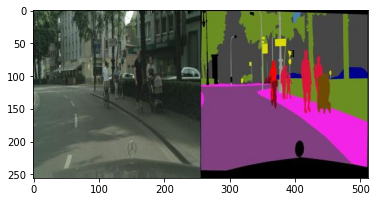

In [4]:
## Sample Image output
sample_image_X = os.path.join(train_dir, train[3])
sample_image = Image.open(sample_image_X).convert("RGB")
plt.imshow(sample_image)
print(sample_image_X)

In [5]:
## Seperate the image into data and label
def split(image):
    image = np.array(image)
    image, label = image[:, :256, :], image[:, 256:, :]
    return image, label

(256, 512, 3)
0 255 0 255


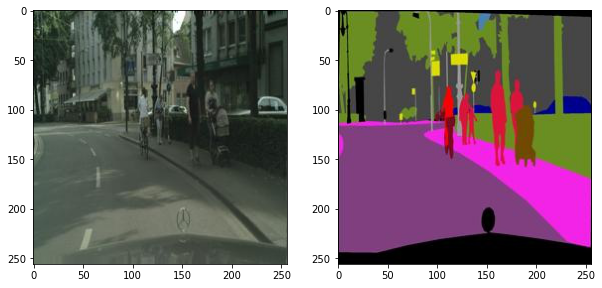

In [6]:
sample_image = np.array(sample_image)
print(sample_image.shape)
image, label = split(sample_image)
print(image.min(), image.max(), label.min(), label.max())

image, label = Image.fromarray(image), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image);
axes[1].imshow(label);

In [7]:
def dataset(data, data_dir):
    
    ## Split train data into train and labels
    X = np.zeros((len(data), 256, 256, 3), dtype=np.float32)
    Y = np.zeros((len(data), 256, 256, 3), dtype=np.float32)

    for i, idx in enumerate(data):
        image_x = os.path.join(data_dir, idx)
        
        #img = Image.open(image_x).convert("RGB")
        img2 = cv2.imread(image_x)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img2 = cv2.normalize(img2, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    
        #img = np.array(img)
        img2 = np.array(img2)
        
        #image, mask = split(img)
        image2, mask2 = split(img2)
    
        X[i] = image2
        Y[i] = mask2
        
    return X, Y

In [8]:
## Train data
train_X, train_Y = dataset(train, train_dir)
#val_X, val_Y = dataset(val, val_dir)

(256, 256, 3)


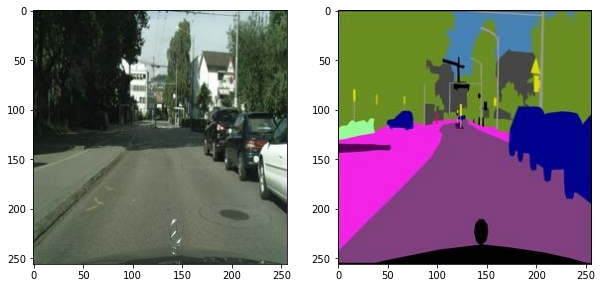

In [9]:
sample_image = train_X[0]
sample_mask = train_Y[0]

print(sample_image.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image);
axes[1].imshow(sample_mask);

In [13]:
from model import UNet

input_shape = (256, 256, 3)
classes = 3
img_size = 256
filters = [16, 32, 64, 128, 256]

unet = UNet(input_shape, classes, img_size, filters, padding='same')

contract 64.0
64.0
expand_64.0 64.0
expand_128.0 128.0
expand_256.0_256.0
expand_512.0_512.0


In [15]:
unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
contracting_path_1_a (Conv2D)   (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           contracting_path_1_a[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          activation[0][0]                 
______________________________________________________________________________________________

## Define Loss

In [14]:
smooth=100

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

## Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 256, 256, 3)


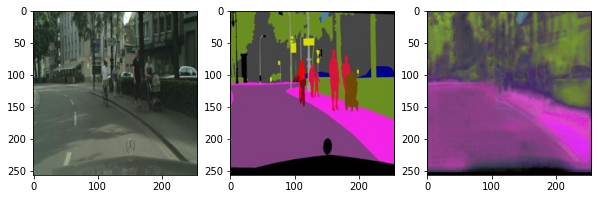

In [23]:
# Predict a mask 
y_pred = unet.predict(train_X[:5])
print (y_pred.shape)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(train_X[3]);
axes[1].imshow(train_Y[3]);
axes[2].imshow(y_pred[3]);

## Fit Model

In [24]:
# Define step decay function
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.3
    epochs_drop = 40.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# learning schedule callback
loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [30]:
optimizer = Adam(lr=0.0)

unet.compile(loss='binary_crossentropy', optimizer=optimizer,
             metrics=['accuracy', iou])

In [55]:
## Fit Model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)

results = unet.fit(train_X, train_Y, validation_split=0.1, batch_size=16, epochs=20, 
                    callbacks=[checkpointer, lrate])

Epoch 1/20
168/168 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.6532 - iou: 0.3654
Epoch 00001: val_loss improved from inf to 0.55885, saving model to model_unet_checkpoint.h5
168/168 [==============================] - 53s 313ms/step - loss: 0.5345 - accuracy: 0.6532 - iou: 0.3654 - val_loss: 0.5588 - val_accuracy: 0.7978 - val_iou: 0.3504 - lr: 0.0010
Epoch 2/20
168/168 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.6677 - iou: 0.3647
Epoch 00002: val_loss did not improve from 0.55885
168/168 [==============================] - 52s 311ms/step - loss: 0.5347 - accuracy: 0.6677 - iou: 0.3647 - val_loss: 0.5591 - val_accuracy: 0.6556 - val_iou: 0.3497 - lr: 0.0010
Epoch 3/20
168/168 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.6578 - iou: 0.3651
Epoch 00003: val_loss did not improve from 0.55885
168/168 [==============================] - 52s 311ms/step - loss: 0.5347 - accuracy: 0.6578 - iou: 0.3651 - val_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 256, 256, 3)


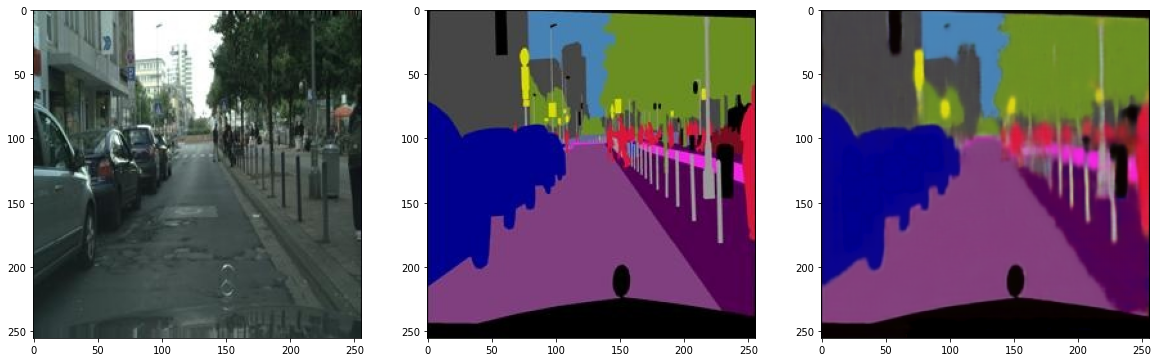

In [56]:
y_pred = unet.predict(train_X[:10])
print (y_pred.shape)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(train_X[5])
axes[1].imshow(train_Y[5])
axes[2].imshow(y_pred[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 256, 256, 3)


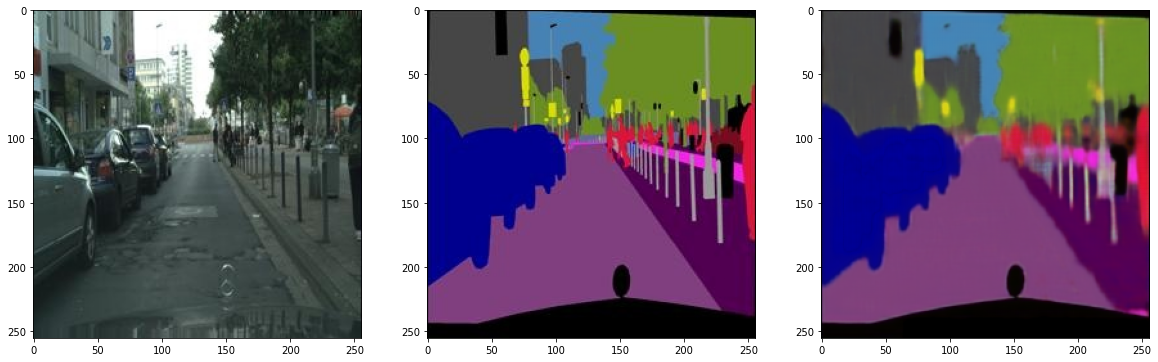

In [51]:
y_pred = unet.predict(train_X[:10])
print (y_pred.shape)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(train_X[5])
axes[1].imshow(train_Y[5])
axes[2].imshow(y_pred[5])

## Train and Validation Loss

dict_keys(['loss', 'accuracy', 'iou', 'val_loss', 'val_accuracy', 'val_iou', 'lr'])


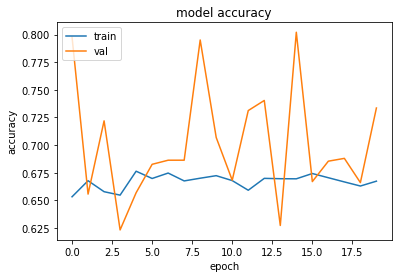

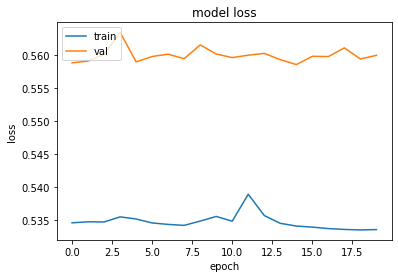

In [57]:
# list all data in history
print(results.history.keys())

# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()